# _Exploring The Tweeterverse: Analyzing @realDonaldTrump's tweets_

In my first post, we got our Twitter API set up to be able to work with, and gather data from, Twitter. As a test run, I decided to pull @realDonaldTrump's most recent 3,199 tweets (as of Oct. 15th). We were able to gather such information as:

- when the tweet was created
- what 'tool' (i.e. iPhone, laptop, etc.) was used to send the tweet
- the retweet and favorite counts
- lastly, the actual text of the tweet

I know the goal of this project is not to focus on Trump specifically, but instead to gauge how "charged" the current political environment is using tweets from political leaders on both sides of the aisle. However, after seeing Senthil's fascinating Medium [post](https://towardsdatascience.com/fun-with-analyzing-billgates-tweets-twitter-apis-step-by-step-analysis-11d9c0448110) that analyzed Bill Gates' tweets, I couldn't help but wonder what a similar analysis might look for the more temperamental Trump. As we learned from our previous work, we're going to have to generate a list of the column names we want to use as well as a dictionary that stores `id` as the key and `str` as the value to assure that the `id` column is read-in as a string/object type.

After we do those two things we can read-in our csv and check out the first few rows!

In [1]:
# import pandas
import pandas as pd
# optional - changes the default setting so that all columns are output for a pandas Df
pd.set_option('display.max_columns', None)

# list containing the column names we want to assign the dataframe
column_names = ['username', 'id', 'created_at', 'source', 'retweet_count', 'favorite_count', 'tweet']

# create dictionary with column name as keys and data types as the values
dtypes = {'id': str}

# create pandas dataframe
trump = pd.read_csv('data/realDonaldTrump_tweets.csv', names=column_names, dtype=dtypes, parse_dates=['created_at'], infer_datetime_format=True)

# check out the first few rows
trump.head()

,username,id,created_at,source,retweet_count,favorite_count,tweet
0,realDonaldTrump,1183908206088728576,2019-10-15 00:51:26,Twitter for iPhone,3183,7994,b'\xe2\x80\x9cProject Veritas-Obtained Underco...
1,realDonaldTrump,1183900672892309505,2019-10-15 00:21:30,Twitter for iPhone,8409,24211,b'A big scandal at @ABC News. They got caught ...
2,realDonaldTrump,1183899559124189184,2019-10-15 00:17:05,Twitter for iPhone,6571,21131,b'Shifty Schiff now seems to think they don\xe...
3,realDonaldTrump,1183873633057476609,2019-10-14 22:34:04,Twitter Media Studio,11785,29106,"b'""The House gone rogue! I want to remind you ..."
4,realDonaldTrump,1183869954640228352,2019-10-14 22:19:27,Twitter Media Studio,10572,27167,"b'""It doesn\'t speak for the FULL HOUSE becaus..."


### _What is the range of dates?_

The first column we'll take a look at is the `created_at` column. According to Twitter, the API technically returns a string-type object that has the UTC time of when the tweet was created. However, using the power of `pandas` we were able to read-in the `created_at` column as a `datetime` type. Additionally, with the co-parameter of `infer_datetime_format` set to `True`, `pandas` even went ahead and inferred the format for us as well! According to the documentation, this has a significant impact on speed, increasing 5-10x. ([Source](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html))

In [2]:
trump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 7 columns):
username          3199 non-null object
id                3199 non-null object
created_at        3199 non-null datetime64[ns]
source            3199 non-null object
retweet_count     3199 non-null int64
favorite_count    3199 non-null int64
tweet             3199 non-null object
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 175.0+ KB


In [3]:
# confirm that created_at column is datetime type
print('Data type for created_at column: {}'.format(trump['created_at'].dtype))

Data type for created_at column: datetime64[ns]


Data type confirmed. Now what I've noticed in resources focused on time-series analysis is that they tend to have the dates as the index column. With our `trump` data set though, our index is a range of integers from 0 to 3198 (remember we gathered 3199 tweets and we're starting at 0). How can we set the `created_at` column as the index? 

Simple: with [`set_index`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html).

(Also, just a heads up I'm going to reassign the name `data` to our subsequent `pandas` dataframe and use that variable for the rest of the notebook.)

In [4]:
# set the index to created_at column and see what the first few rows look like
data = trump.set_index('created_at'); data.head()

,username,id,source,retweet_count,favorite_count,tweet
created_at,,,,,,
2019-10-15 00:51:26,realDonaldTrump,1183908206088728576,Twitter for iPhone,3183,7994,b'\xe2\x80\x9cProject Veritas-Obtained Underco...
2019-10-15 00:21:30,realDonaldTrump,1183900672892309505,Twitter for iPhone,8409,24211,b'A big scandal at @ABC News. They got caught ...
2019-10-15 00:17:05,realDonaldTrump,1183899559124189184,Twitter for iPhone,6571,21131,b'Shifty Schiff now seems to think they don\xe...
2019-10-14 22:34:04,realDonaldTrump,1183873633057476609,Twitter Media Studio,11785,29106,"b'""The House gone rogue! I want to remind you ..."
2019-10-14 22:19:27,realDonaldTrump,1183869954640228352,Twitter Media Studio,10572,27167,"b'""It doesn\'t speak for the FULL HOUSE becaus..."


In [5]:
# When was the most recent tweet tweeted? What abot the oldest tweet?
min_date = data.index.min()
max_date = data.index.max()

print('The dates in our data set range from {}\nat the earliest, and {} being the most recent.'.format(min_date, max_date))

The dates in our data set range from 2019-05-23 02:28:36
at the earliest, and 2019-10-15 00:51:26 being the most recent.


Looks like the tweets started on May 23rd, and go all the way through October 15th wo we're working with a few months worth of tweets. 

You may be asking though: what's the benefit of using `Datetime` as an index? To put it succintly, using a [`DatetimeIndex`](https://pandas.pydata.org/pandas-docs/version/0.25/reference/api/pandas.DatetimeIndex.html) packs some cool features for time-series analysis:
- by grabbing just a slice of dates, we can generate subsequent date ranges very fast
- regularization functions like [`snap`](https://pandas.pydata.org/pandas-docs/version/0.25/reference/api/pandas.DatetimeIndex.snap.html) and [`asof`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.asof.html) 
- perhaps most importantly, the ability quickly access properties like the year, month, or even day of the week

([Source](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#indexing))

We'll start by playing around with all the subproperties that we can extract, like the `hour` of the day, or what `weekday` it is. 

In [6]:
# quick example showing the hour that the tweet was created
for n in range(5):
    print(data.index[n].hour)

0
0
0
22
22


In [7]:
# another quick example showing the day of the week for the tweet
for n in range(5):
    print(data.index[n].dayofweek)

1
1
1
0
0


Quick note: when we use either `dayofweek` or `weekday`, a number between 0 and 6 is going to be returned. A value of 0 is equal to Monday and a value of 6 is equal to Sunday.

However, there is also [`day_name`](https://pandas.pydata.org/pandas-docs/version/0.25/reference/api/pandas.Series.dt.day_name.html#pandas.Series.dt.day_name) which returns the actual day of the week.

In [8]:
# print out the day name for the first 5 observations
for n in range(5):
    print(data.index[n].day_name())

Tuesday
Tuesday
Tuesday
Monday
Monday


In [9]:
# we could even return the name of the day in another language like German!
for n in range(5):
    print(data.index[n].day_name(locale='de_DE'))

Dienstag
Dienstag
Dienstag
Montag
Montag


In [10]:
# or in Russian...
for n in range(5):
    print(data.index[n].day_name(locale='ru_RU'))

Вторник
Вторник
Вторник
Понедельник
Понедельник


Now that we know how to add additional information about when these tweets were tweeted, let's go ahead and add them our data!

In [11]:
# month
month = data.index.month.to_list()
# day (number) of the datetime
day = data.index.day.to_list()
# hour of the day for each observation
hour = data.index.hour.to_list()
# ordinal day of year
dayofyear = data.index.dayofyear.to_list()
# week ordinal of the year
weekofyear = data.index.weekofyear.to_list()
# day of the week
dayofweek = data.index.day_name().to_list()

In [12]:
# create a dictionary with keys as the column name and its corresponding values 
new_cols = {'month': month, 'day': day, 'hour': hour, 'dayofyear': dayofyear, 
           'dayofweek': dayofweek}

For now I think that is plenty of datetime information to work with! Now we're going to insert these extracted values into `data` using [`insert`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html), which allows us to insert a column at a specified location.

In [13]:
# index we want to start, will count up to indicate new loc
start_index = 0

# loop through key, values in dictionary with new columns
# inserting at value stored in start_index, column name as key string, and keys associated
# values
for key, vals in new_cols.items():
    data.insert(loc=start_index, column=str(key), value=vals)
    start_index += 1

In [16]:
# check out first few rows to make sure it worked
data.head()

,month,day,hour,dayofyear,dayofweek,username,id,source,retweet_count,favorite_count,tweet
created_at,,,,,,,,,,,
2019-10-15 00:51:26,10,15,0,288,Tuesday,realDonaldTrump,1183908206088728576,Twitter for iPhone,3183,7994,b'\xe2\x80\x9cProject Veritas-Obtained Underco...
2019-10-15 00:21:30,10,15,0,288,Tuesday,realDonaldTrump,1183900672892309505,Twitter for iPhone,8409,24211,b'A big scandal at @ABC News. They got caught ...
2019-10-15 00:17:05,10,15,0,288,Tuesday,realDonaldTrump,1183899559124189184,Twitter for iPhone,6571,21131,b'Shifty Schiff now seems to think they don\xe...
2019-10-14 22:34:04,10,14,22,287,Monday,realDonaldTrump,1183873633057476609,Twitter Media Studio,11785,29106,"b'""The House gone rogue! I want to remind you ..."
2019-10-14 22:19:27,10,14,22,287,Monday,realDonaldTrump,1183869954640228352,Twitter Media Studio,10572,27167,"b'""It doesn\'t speak for the FULL HOUSE becaus..."


In [17]:
# confirm they are integer types (except for dayofweek)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3199 entries, 2019-10-15 00:51:26 to 2019-05-23 02:28:36
Data columns (total 11 columns):
month             3199 non-null int64
day               3199 non-null int64
hour              3199 non-null int64
dayofyear         3199 non-null int64
dayofweek         3199 non-null object
username          3199 non-null object
id                3199 non-null object
source            3199 non-null object
retweet_count     3199 non-null int64
favorite_count    3199 non-null int64
tweet             3199 non-null object
dtypes: int64(6), object(5)
memory usage: 299.9+ KB


Everything is looking good up to this point! 

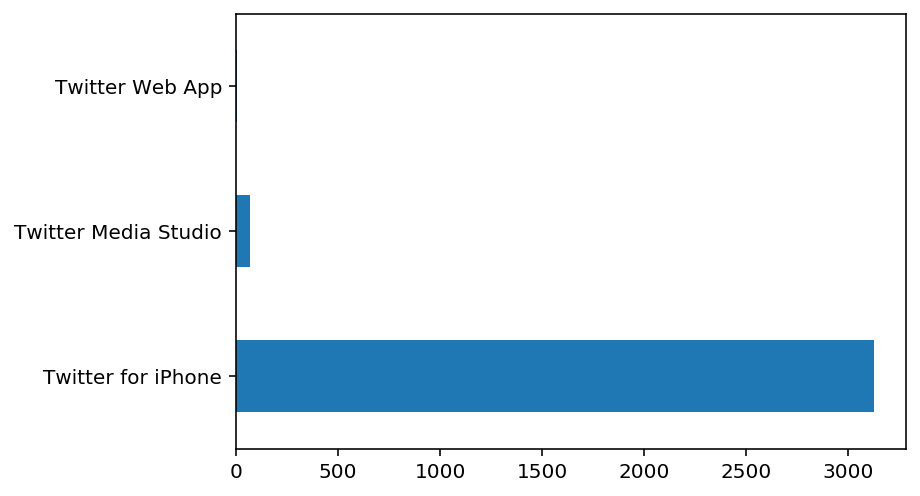

In [20]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

data['source'].value_counts().plot.barh();

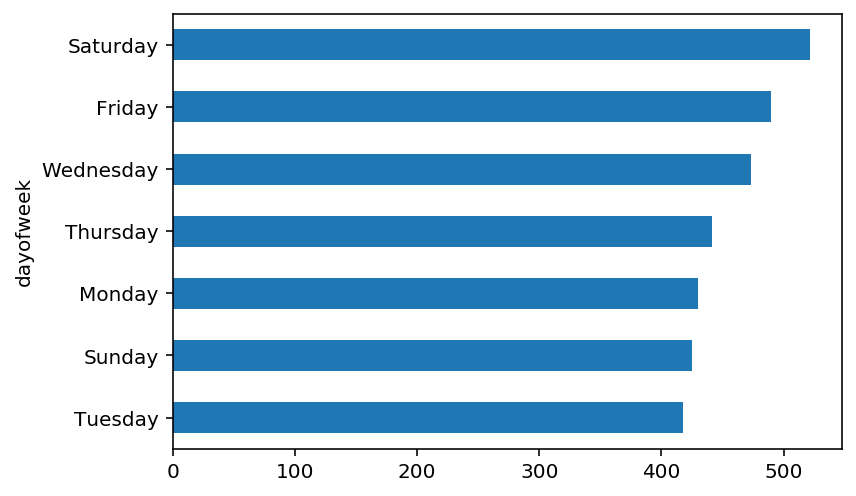

In [38]:
data.groupby('dayofweek')['tweet'].agg('count').sort_values().plot.barh();

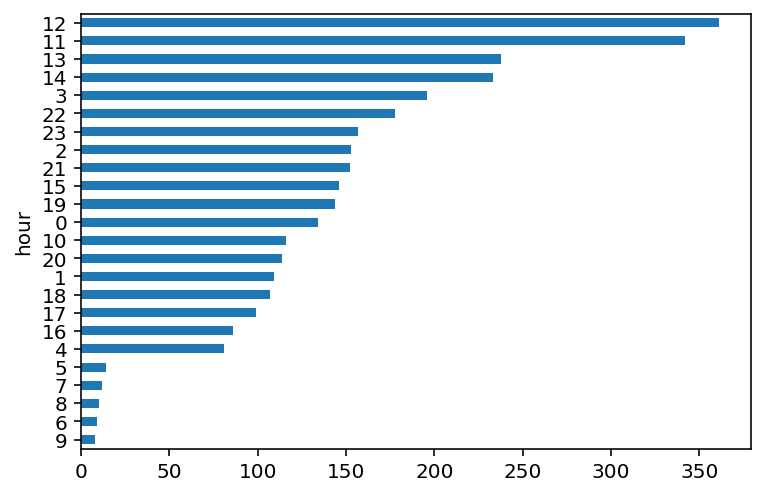

In [47]:
data.groupby('hour')['tweet'].agg('count').sort_values().plot.barh();

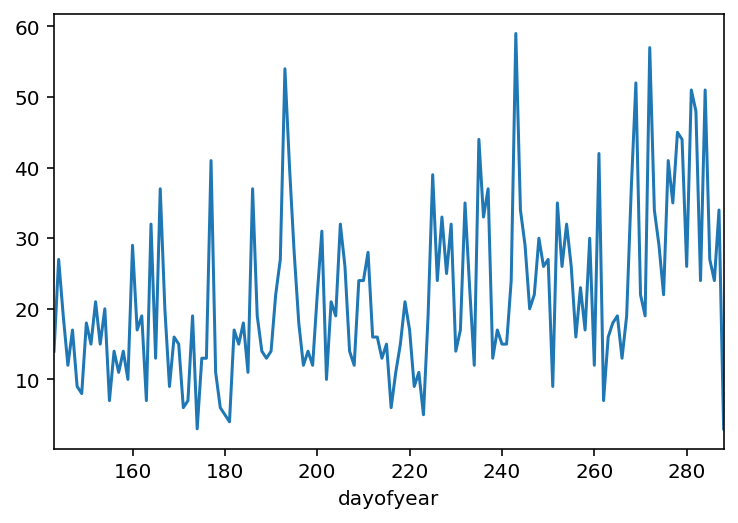

In [50]:
data.groupby('dayofyear')['tweet'].agg('count').plot.line();